<a href="https://colab.research.google.com/github/alanamer/20.440PSET6/blob/main/alana_GO_primary_vs__diff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code file will allow you to generate two figures of of differentially expressed genes in iPSC-derived vs. primary cardiomyocytes using transcriptome data from GSE146096 (Primary cardiomyocytes, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE146096) and GSE226159 (iPSC-derived cardiomyocytes, https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM7065927) from the NIH Gene Expression Omnibus (GEO) database.

RNA count normalization and differential expression analysis will be performed using the DESeq2 implementation in Python (PyDESeq2 https://bioconductor.org/packages/release/bioc/html/DESeq2.html), and then differentially expressed genes based on the criteria of adjusted p-value (FDR) > 0.05 and |log2 fold change| > 2 will be passed to the package PyKEGG (https://pypi.org/project/pykegg/) which allows visualization of KEGG information using a network approach.

In [ ]:
# begin by installing necessary packages

%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit

from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz


import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
#run DeSEQ

#upload the data file of transcriptome data for iPSC-derived and primary cardiomyocytes

#edit the path to be the location of the data for you
merged = pd.read_csv('data_files/MetaData_iPSCvsPrimary.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged = merged.astype(int)

In [ ]:
# add labels for Primary cardiomyocytes and iPSC-derived
labels = ['Primary'] * 5 + ['hiPSC'] * 6

#format the data for DeSeq
metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [ ]:
dds = DeseqDataSet(counts=merged.iloc[0:11],
            metadata=metadata,
            design_factors="Condition")

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.06 seconds.

Fitting dispersions...
... done in 17.95 seconds.

Fitting dispersion trend curve...
... done in 0.57 seconds.

Fitting MAP dispersions...
... done in 23.77 seconds.

Fitting LFCs...
... done in 15.71 seconds.

Replacing 0 outlier genes.



In [ ]:
#obtain the data, specifically for log2FoldChange for each gene
stat_res = DeseqStats(dds, contrast = ('Condition','Primary','hiPSC'))

stat_res.summary()
res = stat_res.results_df

Running Wald tests...


Log2 fold change & Wald test p-value: Condition Primary vs hiPSC
           baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
A1BG       6.032835        1.995937  0.929305  2.147775  0.031732  0.071470
NAT2       0.000000             NaN       NaN       NaN       NaN       NaN
ADA        4.575419       -1.649291  0.801497 -2.057762  0.039613  0.085633
CDH2      80.088962        2.534286  0.601957  4.210076  0.000026  0.000176
AKT3       7.747054       -1.860110  0.882132 -2.108654  0.034974  0.077389
...             ...             ...       ...       ...       ...       ...
PTBP3     63.514263       -1.634078  0.390688 -4.182562  0.000029  0.000195
KCNE2      0.000000             NaN       NaN       NaN       NaN       NaN
DGCR2     14.768740       -0.922853  0.453863 -2.033331  0.042019  0.089654
CASP8AP2  13.483534        0.459512  0.449577  1.022098  0.306735  0.421790
SCO2       3.971019        3.407379  1.856020  1.835852  0.066380  0.128185

[18529 rows x 6 column

... done in 4.40 seconds.



In [ ]:
stat_res_summary = stat_res.results_df
#drop nan rows
stat_res_summary = stat_res_summary.dropna()


In [ ]:
sig_genes = stat_res_summary[stat_res_summary.padj<0.05].index
lfc_key = stat_res_summary.log2FoldChange.to_dict()

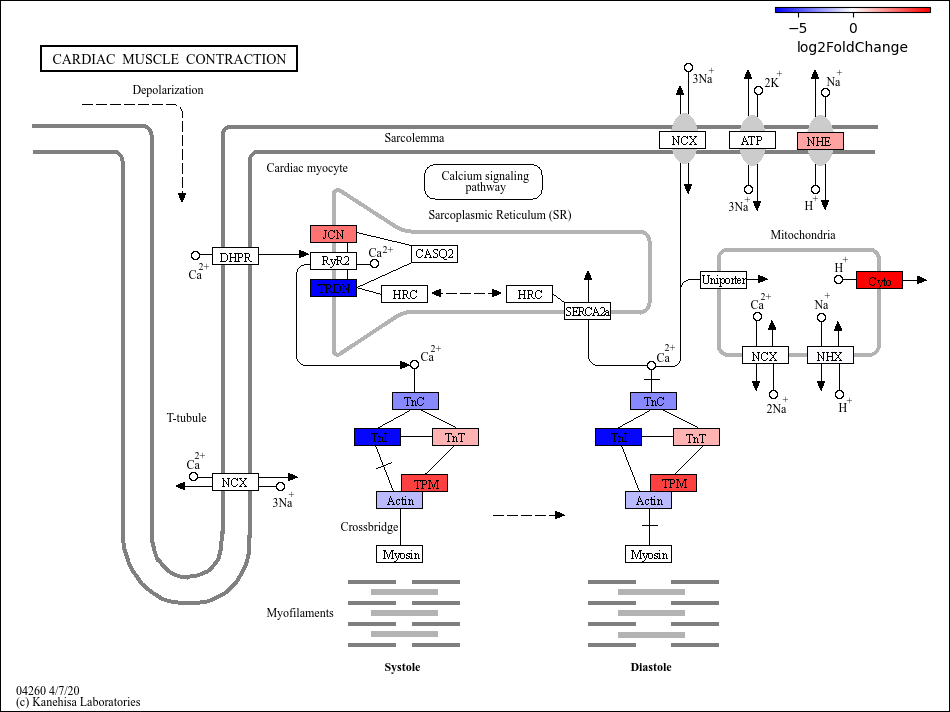

In [ ]:
#use the pyKegg package to visualize the DEG information
#!pip install pykegg
#!pip install requests_cache
import pykegg
import requests_cache
import numpy as np
from PIL import Image

## Cache all the downloaded
requests_cache.install_cache('pykegg_cache')
#replace the pid with the KEGG pathway you want to generate for
#more KEGG pathways can be viewed here: https://www.genome.jp/kegg-bin/show_organism?menu_type=pathway_maps&org=hsa
#Cardiac muscle contraction is hsa04260
#vascular smooth muscle contraction is hsa04270
graph = pykegg.KGML_graph(pid="hsa04260")
nds = graph.get_nodes()
highlight_value = []


## If one of the symbols in identifiers in the nodes is in DEGs
for node in nds.graphics_name:
    in_node = [i.replace("...","") for i in node.split(",")]
    intersect = set(in_node) & set(sig_genes)
    if len(intersect) > 0:
        highlight_value.append(True)
    else:
        highlight_value.append(False)

nds = pykegg.append_colors_continuous_values(nds, lfc_key)
nds["highlight"] = highlight_value
#replace the pid with the KEGG pathway you want to generate for
Image.fromarray(pykegg.overlay_opencv_image(nds,
                                            pid="hsa04260",
                                            highlight_nodes="highlight"))
#replace the pid with the KEGG pathway you want to generate for
#Cardiac muscle contraction
pykegg.deseq2_raw_map(stat_res_summary, pid="hsa04260", legend_width=2)



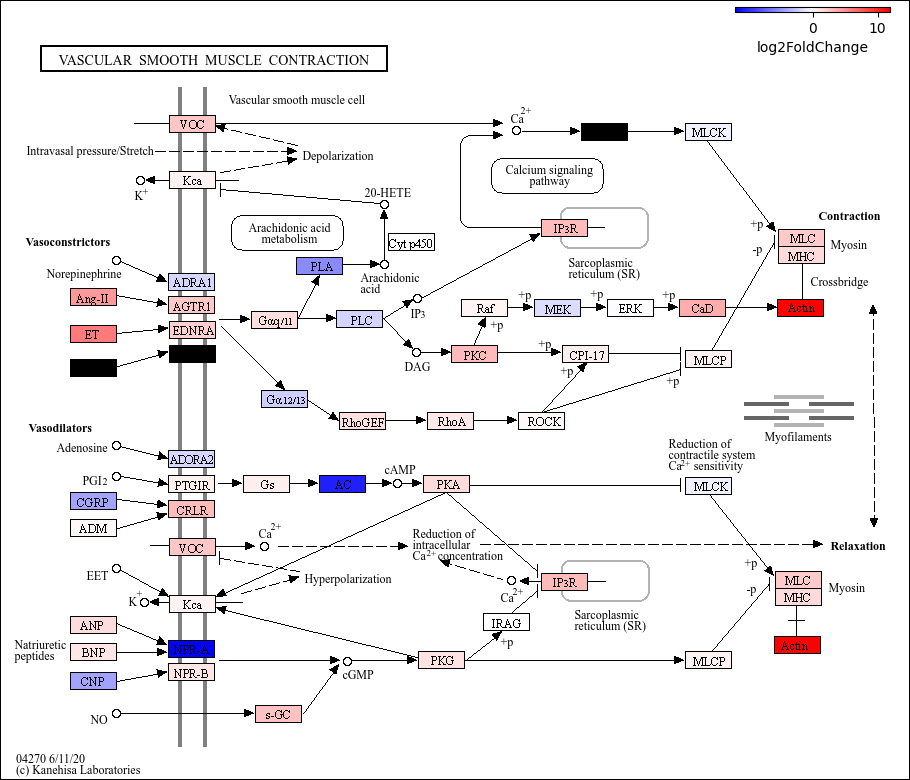

In [ ]:

 # Pull the ipsc vs primary pathways
primary_v_ipsc = pd.read_csv('GSEA/OG_primary.tsv', delimiter='\t')

#sort by normalized enrichment score, abs

primary_v_ipsc = primary_v_ipsc.reindex(primary_v_ipsc['nes'].abs().sort_values(ascending=False).index)



In [ ]:
#pull the top 20 pathways
primary_v_ipsc_sorted_top20 = primary_v_ipsc.head(20).copy()

#assign terms and normalizaed enrichment score to variables for plotting
terms = primary_v_ipsc_sorted_top20['Term']
nes = primary_v_ipsc_sorted_top20['nes'].abs() # Taking absolute value



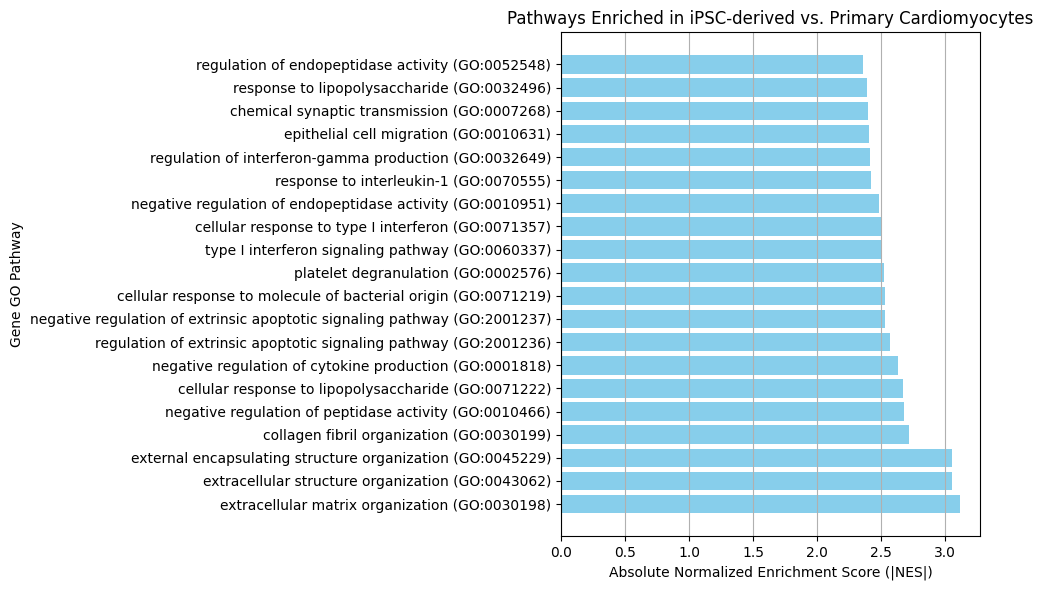

In [ ]:
#plot bar graph of normalized enrichment score for the top 20 pathways enriched in iPSC vs primary
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.barh(terms, nes, color='skyblue')
plt.xlabel('Absolute Normalized Enrichment Score (|NES|)')  # x-axis label
plt.ylabel('Gene GO Pathway')
plt.title('Pathways Enriched in iPSC-derived vs. Primary Cardiomyocytes')
plt.grid(axis='x')
plt.tight_layout()
plt.show()
